In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
# Defining the working directories

work_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images/'

In [2]:
#%% IMPORTING DATA

# Importing train.csv

data = pd.read_csv(work_dir + 'train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels


Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


CLASS DISTRIBUTION

As seen in the below histogram the dataset is imbalance.

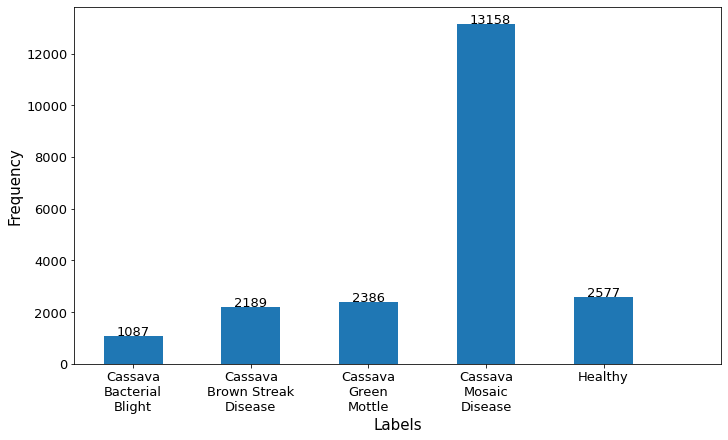

In [3]:
# Plot a histogram -> depicted in the background section
import matplotlib.pyplot as plt

disease_labels = {
    0: 'Cassava\nBacterial\nBlight',
    1: 'Cassava\nBrown Streak\nDisease',
    2: 'Cassava\nGreen\nMottle',
    3: 'Cassava\nMosaic\nDisease',
    4: 'Healthy'
}

w = 0.5
label_dist = Counter(data['label'])
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.hist(x=data['label'], bins=np.arange(6)-w/2, width=w)
ax.set_xlabel('Labels', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)

i = 0
for val in disease_labels.keys():
    ax.text(x=i-0.14, y=int(label_dist[i])+8, s=label_dist[i], fontsize=13)
    i+=1
    
plt.xticks(ticks=list(disease_labels.keys()), labels=list(disease_labels.values()), rotation=0)
plt.savefig('disease_distribution.pdf', dpi=100)

In [4]:
# Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)
print(data.head(10))
print(data['class_name'].unique())

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
5  1000837476.jpg      3         Cassava Mosaic Disease (CMD)
6  1000910826.jpg      2           Cassava Green Mottle (CGM)
7  1001320321.jpg      0       Cassava Bacterial Blight (CBB)
8  1001723730.jpg      4                              Healthy
9  1001742395.jpg      3         Cassava Mosaic Disease (CMD)
['Cassava Bacterial Blight (CBB)' 'Cassava Mosaic Disease (CMD)'
 'Cassava Brown Streak Disease (CBSD)' 'Cassava Green Mottle (CGM)'
 'Healthy']


In [5]:
def showImages(images):

    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(16)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
    for i in range(16):
        plt.subplot(4,4, i + 1)
        img = plt.imread(train_path+'/'+random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

In [6]:
mask = data['label'] == 4
classHealthy = data[mask]

In [7]:
# showImages(classHealthy['image_id'])

In [8]:
mask = data['label'] ==3
classCMD = data[mask]

In [9]:
# showImages(classCMD['image_id'])

In [10]:
mask = data['label'] ==2
classCGM = data[mask]

In [11]:
# showImages(classCGM['image_id'])

In [12]:
mask = data['label'] ==1
classCBSD = data[mask]

In [13]:
# showImages(classCBSD['image_id'])

As you can see above images, there are noisy labels


In [14]:
mask = data['label'] ==0
classCBB = data[mask]

In [15]:
# showImages(classCBB['image_id'])

In [16]:
# Augmentations
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
import cv2
import tensorflow as tf
from PIL import Image
import scipy.misc

IMG_SIZE = 512

transform = Compose([
    RandomResizedCrop(IMG_SIZE, IMG_SIZE),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(p=0.5),
])

transformed_images = []
for i in range(len(data.index)):
    curr_img = data.iloc[i:i+1, :]
    img = cv2.imread(train_path + curr_img['image_id'].values[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    aug_img = transform(image=img)['image']
    norm_aug_img = np.array(tf.cast(aug_img / 255.0, tf.float32))
    image_id = 'aug_' + curr_img['image_id'].values[0]
    img = dict({
        'image_id': image_id,
        'label': curr_img['label'].values[0],
        'class_name': curr_img['class_name'].values[0],
        'pixels': norm_aug_img
    })
    
    im = Image.fromarray(aug_img)
    
    aug_images_dir_path = 'aug_train_images/'
    
    if not os.path.exists(aug_images_dir_path):
        os.makedirs(aug_images_dir_path)
        
    im.save(aug_images_dir_path + str(image_id)) # save

    # Remove when training 
    if i < 100:
        transformed_images.append(img)
    else:
        break


In [17]:
dic = {"label": str(data.iloc[1:2, :]["label"].values[0])}
dic

{'label': '3'}

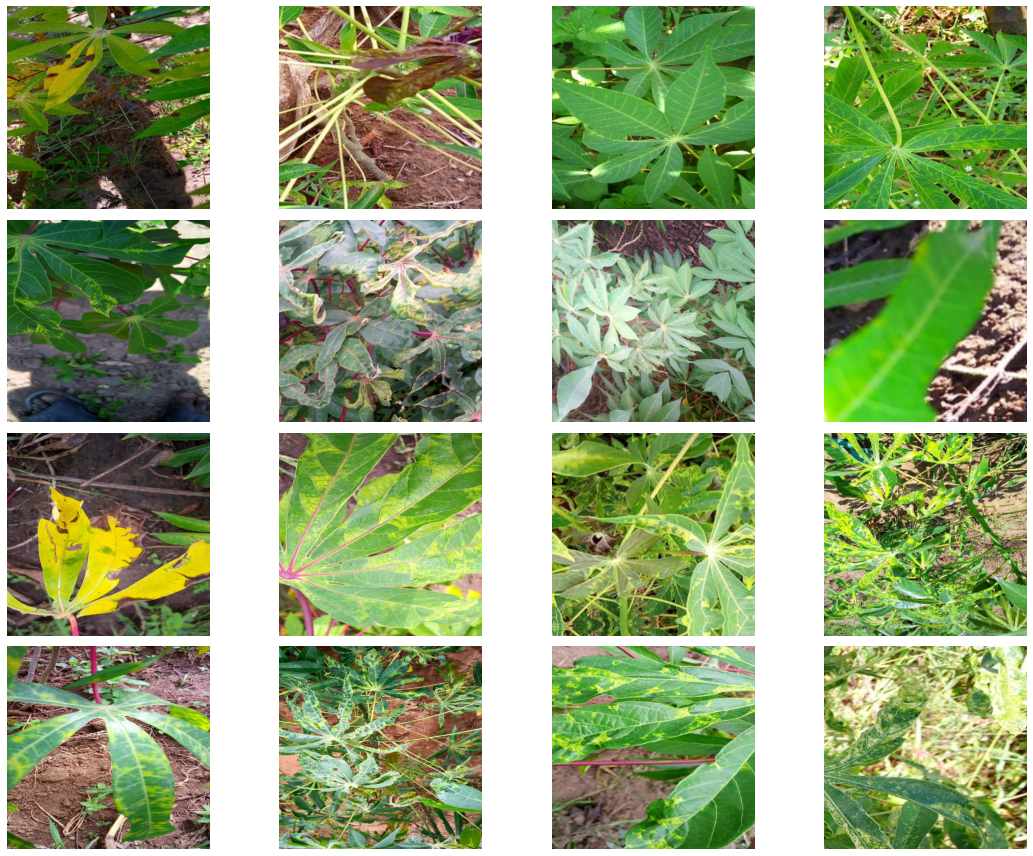

In [18]:
# Adjust the size of your images
plt.figure(figsize=(16,12))
# print(transformed_images[i])
# Iterate and plot random images
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(transformed_images[i]['pixels'], cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [27]:
# Copied from: https://www.kaggle.com/marto24/keras-model-89-tta
# Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.10, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 512
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


In [31]:
EPOCHS = 10
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
N_CLASSES = 5

In [ ]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

efficientNetB0 = tf.keras.applications.EfficientNetB0(
    include_top=True, weights=None, input_tensor=None,
    input_shape=INPUT_SHAPE, pooling=None, classes=N_CLASSES,
    classifier_activation='softmax', drop_connect_rate=0.4
)

mobileNetV3Small = tf.keras.applications.MobileNetV3Small(
    input_shape=INPUT_SHAPE, alpha=0.7, minimalistic=True, include_top=True,
    weights=None, input_tensor=None, classes=N_CLASSES, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax'
)

resNet50V2 = tf.keras.applications.ResNet50V2(
    include_top=True, weights=None, input_tensor=None,
    input_shape=INPUT_SHAPE, pooling=None, classes=N_CLASSES,
    classifier_activation='softmax'
)

selected_architecture = mobileNetV3Small

# for layer in selected_architecture.layers[:20]:  # Training just part of the architecture do not optimize the performance
#     layer.trainable = False
    
model = tf.keras.Model(inputs, selected_architecture(inputs))
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

epochs = 10 

hist = model.fit(train_set, 
                 epochs=epochs, 
                 validation_data=val_set,
                 batch_size = BATCH_SIZE,
                 steps_per_epoch = STEP_SIZE_TRAIN,
                 validation_steps = STEP_SIZE_VALID)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 5)                 618181    
Total params: 618,181
Trainable params: 609,637
Non-trainable params: 8,544
_________________________________________________________________
Epoch 1/10
 81/601 [===>..........................] - ETA: 17:00 - loss: 1.2305 - accuracy: 0.5669